In [1]:
import matplotlib.pyplot as plt
import numpy as np

For this chapter, for ease of notation, we will make it synonymous between task, process and thread.

Previous for [scheduling](./scheduling.ipynb), we'd assumed that the tasks are independent.
However, usually when tasks are being ran together, there is some level of communication and dependency required between them.
With parallel/concurrent executions, communication is not straightforward.

# Synchronization

Hence, to enforce some ordering of the tasks, the tasks have to synchronize their actions,
therein lies some issues that we may face.

## Race condition

**Race condition** occurs when concurrent access to some shared data, which leads to data inconsistency.

In [2]:
import threading
import time

count = 0


def inc():
    global count
    new_count = count + 1

    time.sleep(1e-4)  # Simulate some work

    count = new_count


num_threads = 100
threads = [threading.Thread(target=inc) for _ in range(num_threads)]

for t in threads:
    t.start()

for t in threads:
    t.join()

count

29

As we can see, we are under-counting, because the value read in the thread is no longer correct once some other thread updates the value.
Even if we'd avoid using `sleep` to simulate the work, it is still possible for under-counting to occur if the task is preempted between its reading and writing instructions.

## Critical section


A **critical section** is a code segment where shared data is accessed, and **at least 1 process modifies the shared data**.

Hence, to ensure consistency, we need to enforce that when a process is executing its critical section, no other process is allowed execute that section.

Each process needs to obtain "permission" to execute its critical section, and relinquish it once it is ran.

Hence, to ensure data consistency, we need some mechanism to ensure the orderly execution of processes.

## OS support

The OS provides the following support for critical sections:
* Synchronization hardware
* Semaphore

## Synchronization hardware

Modern hardware provides special **atomic** hardware instructions.
These instructions are non-interruptable.
We can use these to achieve synchronization.

``` c
bool getLock(bool *lock) {
    // assumes that this function is implemented using atomic operations
    bool val = *lock
    *lock = true
    return val
}


// Process code (lock is a shared variable)
while (1) {
    while (getLock(&lock)) {} // wait for lock
    
    // critical section
    
    lock = false
    
    // non-critical section
}
```

## Semaphore

A semaphore is a general inter-process synchronization framework.
It is essentially a [queue](../data_structures/linked_list.ipynb#Queue).
It has some value $x$, and has 2 atomic operations:
* `acquire`: Decrements $x$ if $x> 0$, otherwise blocks the process and add it to the queue
    * traditionally called $P(s)$, from the Dutch word for "try to reduce": _prolaag_
* `release`: Increments $x$ if the queue is empty, otherwise remove a process from the queue and unblocks it
    * traditionally called $V(s)$, from the Dutch word for "release": _vrijgave_

Suppose that we have an application that constantly makes network request via separate processes.
However, our system can only handle 5 concurrent requests at the same time.
Thus, it makes sense for us to use a semaphore to organize the requests such that only 5 concurrent requests are being made at once.

Whenever a request begins, it will check if $x > 0$, which corresponds if there are still capacity for more network requests.
If there are still capacity, it reduces $x$ and performs its request.
Otherwise, it is blocked and moved into the queue.

Once a request completes, it releases the resource.
It increments $x$ if there is no blocked processes, otherwise it removes one from the queue and unblocks it, allowing it to use the freed-up resource.

In [3]:
count = 0
semaphore = threading.Semaphore(3)


def inc():
    global count

    semaphore.acquire()
    # start of critical section
    new_count = count + 1

    time.sleep(0.1e-4)  # Simulate some work

    count = new_count
    # end of critical section

    semaphore.release()


num_threads = 100
threads = [threading.Thread(target=inc) for _ in range(num_threads)]

for t in threads:
    t.start()

for t in threads:
    t.join()

count

57

When we used a semaphore of size 3, it helped with our under-counting, but it didn't solve it.
This is because it is still possible for the 3 processes that are running to encounter race condition.

We can also use semaphores to enforce some ordering of processes.

Suppose that we have require that a certain step of process B be executed only after process A is done.

In [4]:
def funcA():
    print("func A starting")
    time.sleep(3)  # simulate some work
    print("func A ended")


def funcB():
    print("func B starting")
    time.sleep(0.5)  # simulate some work

    print("func B reached point where it requires process A's completion")
    time.sleep(0.5)  # simulate some work
    print("func B continues")
    time.sleep(0.5)  # simulate some work
    print("func B ended")


tA = threading.Thread(target=funcA)
tB = threading.Thread(target=funcB)
tA.start()
tB.start()
tA.join()
tB.join()

func A starting
func B starting
func B reached point where it requires process A's completion
func B continues
func B ended
func A ended


Without semaphores, the above would be the output, as process B does not wait for process A.

Now with semaphores:

In [5]:
semaphore = threading.Semaphore(0)


def funcA():
    print("func A starting")
    time.sleep(3)  # simulate some work
    print("func A ended")
    semaphore.release()


def funcB():
    print("func B starting")
    time.sleep(0.5)  # simulate some work

    print("func B reached point where it requires process A's completion")
    semaphore.acquire()
    time.sleep(0.5)  # simulate some work
    print("func B continues")
    time.sleep(0.5)  # simulate some work
    print("func B ended")


tA = threading.Thread(target=funcA)
tB = threading.Thread(target=funcB)
tA.start()
tB.start()
tA.join()
tB.join()

func A starting
func B starting
func B reached point where it requires process A's completion
func A ended
func B continues
func B ended


Initially, $x=0$, hence process B is unable to continue its execution when it reached the section where it needs to acquire the semaphore.
Once process A completes, it will release the semaphore for process B, hence acting as a signaling tool between the two processes.

### Binary semaphore

A **binary semaphore** is simply a special case of a semaphore which has a capacity of 1.

In [6]:
count = 0
semaphore = threading.Semaphore(1)


def inc():
    global count

    semaphore.acquire()
    # start of critical section
    new_count = count + 1

    time.sleep(0.1e-4)  # Simulate some work

    count = new_count
    # end of critical section

    semaphore.release()


num_threads = 100
threads = [threading.Thread(target=inc) for _ in range(num_threads)]

for t in threads:
    t.start()

for t in threads:
    t.join()

count

100

By using a binary semaphore, we can ensure that only 1 thread can access the critical section, and hence the data stays consistent, as shown above.

### Mutex

As an aside, a **mutex** (mutual exclusion) is a mechanism that is similar to a binary semaphore.
The main difference is that only the process that acquires the lock can release it, while a binary semaphore (strictly speaking) allows for another process to release the semaphore.

Hence, traditionally, the slight nuance means that mutexes is used to obtain some shared resource, while a binary semaphore is used to signal to other processes about the status of a process.

In [7]:
count = 0
mutex = threading.Lock()


def inc():
    global count

    mutex.acquire()

    # start of critical section
    new_count = count + 1

    time.sleep(0.1e-6)  # Simulate some work

    count = new_count
    # end of critical section

    mutex.release()


num_threads = 100
threads = [threading.Thread(target=inc) for _ in range(num_threads)]

for t in threads:
    t.start()

for t in threads:
    t.join()

count

100

In our case, a mutex also serves to prevent race conditions.

## Issues with synchronization


### Deadlock

A **deadlock** occurs when two or more processes are waiting for an event that can be caused by only 1 of the waiting processes.

``` python 
semaphoreA = threading.Semaphore(1)
semaphoreB = threading.Semaphore(1)
def funcA():
    semaphoreA.acquire()
    semaphoreB.acquire()

    semaphoreA.release()
    semaphoreB.release()
    
def funcB():
    semaphoreB.acquire()
    semaphoreA.acquire()

    semaphoreA.release()
    semaphoreB.release()
    
```

In this case, it is possible for process A to obtain semaphore A while process B obtains semaphore B.
Then, both processes will be in a deadlock, as process A will be blocked when trying to obtain semaphore B, and similarly for process B.

This is a rather dense topic, and hence postponed for discussion in the [deadlock chapter](./deadlock.ipynb).

### Priority inversion

Suppose that we have a high priority task $H$, a medium priority task $M$ and a low priority task $L$.
Consider the case where both $H$ and $L$ requires some shared resource to run.

**Priority inversion** is the situation where $H$ is delayed because $L$ is holding the lock, but $M$ is delaying $L$ from completing its task and releasing the lock.

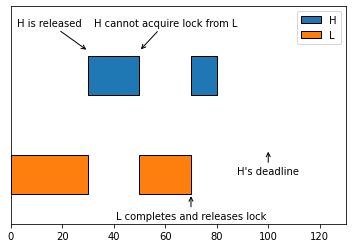

In [8]:
plt.barh(y=2, width=[20, 10], left=[30, 70], label="H", edgecolor="black")
plt.barh(y=0, width=[30, 20], left=[0, 50], label="L", edgecolor="black")
plt.annotate(
    "H is released",
    xy=(30, 2.5),
    xytext=(15, 3),
    ha="center",
    arrowprops={"arrowstyle": "->"},
)
plt.annotate(
    "H cannot acquire lock from L",
    xy=(50, 2.5),
    xytext=(60, 3),
    ha="center",
    arrowprops={"arrowstyle": "->"},
)
plt.annotate(
    "L completes and releases lock",
    xy=(70, -0.4),
    xytext=(70, -0.9),
    ha="center",
    arrowprops={"arrowstyle": "->"},
)
plt.annotate(
    "H's deadline",
    xy=(100, 0.5),
    xytext=(100, 0),
    ha="center",
    arrowprops={"arrowstyle": "->"},
)
plt.yticks([])
plt.ylim(-1, 3.4)
plt.xlim(0, 130)
plt.legend()
plt.show()

In a typical situation, $C$ is able to complete in time, hence allowing $A$ to resume and meet its deadline.
Now suppose that $B$ enters the picture.

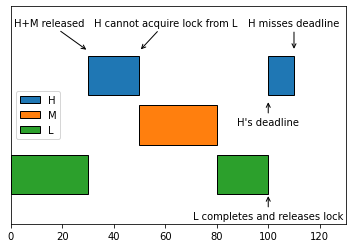

In [9]:
plt.barh(y=2, width=[20, 10], left=[30, 100], label="H", edgecolor="black")
plt.barh(y=1, width=[30], left=[50], label="M", edgecolor="black")
plt.barh(y=0, width=[30, 20], left=[0, 80], label="L", edgecolor="black")
plt.annotate(
    "H+M released",
    xy=(30, 2.5),
    xytext=(15, 3),
    ha="center",
    arrowprops={"arrowstyle": "->"},
)
plt.annotate(
    "H cannot acquire lock from L",
    xy=(50, 2.5),
    xytext=(60, 3),
    ha="center",
    arrowprops={"arrowstyle": "->"},
)
plt.annotate(
    "L completes and releases lock",
    xy=(100, -0.4),
    xytext=(100, -0.9),
    ha="center",
    arrowprops={"arrowstyle": "->"},
)
plt.annotate(
    "H's deadline",
    xy=(100, 1.5),
    xytext=(100, 1),
    ha="center",
    arrowprops={"arrowstyle": "->"},
)
plt.annotate(
    "H misses deadline",
    xy=(110, 2.5),
    xytext=(110, 3),
    ha="center",
    arrowprops={"arrowstyle": "->"},
)
plt.yticks([])
plt.ylim(-1, 3.4)
plt.xlim(0, 130)
plt.legend(loc="center left")
plt.show()

Now, the task that is started after $H$ sleeps is $M$.
And $M$ is delaying the completion of $L$, which effectively delays $H$, causing it to miss its deadline.

#### Solution

The solution is rather simple.
We perform **priority inheritance**, where if a high priority task is sleeps due to being unable to acquire a lock, the task that has the lock has its priority **temporarily** raised to that of the high priority task.

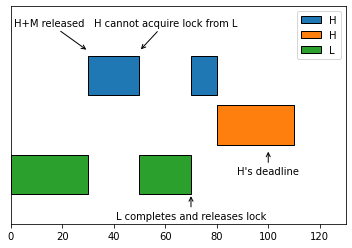

In [10]:
plt.barh(y=2, width=[20, 10], left=[30, 70], label="H", edgecolor="black")
plt.barh(y=1, width=30, left=80, label="H", edgecolor="black")
plt.barh(y=0, width=[30, 20], left=[0, 50], label="L", edgecolor="black")
plt.annotate(
    "H+M released",
    xy=(30, 2.5),
    xytext=(15, 3),
    ha="center",
    arrowprops={"arrowstyle": "->"},
)
plt.annotate(
    "H cannot acquire lock from L",
    xy=(50, 2.5),
    xytext=(60, 3),
    ha="center",
    arrowprops={"arrowstyle": "->"},
)
plt.annotate(
    "L completes and releases lock",
    xy=(70, -0.4),
    xytext=(70, -0.9),
    ha="center",
    arrowprops={"arrowstyle": "->"},
)
plt.annotate(
    "H's deadline",
    xy=(100, 0.5),
    xytext=(100, 0),
    ha="center",
    arrowprops={"arrowstyle": "->"},
)
plt.yticks([])
plt.ylim(-1, 3.4)
plt.xlim(0, 130)
plt.legend()
plt.show()

In this case, $L$ is ran instead of $M$ when $H$ sleeps, because it has higher priority than $M$ due to priority inheritance.
This ensures that $H$ meets its deadline.